In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
import gpytorch.means as means
from botorch.utils.transforms import normalize

from autorocks.data.dataset import BOSystemDataset
from autorocks.data.debugger import OfflineDebugger
from autorocks.dir_struct import LocalResultDir
from autorocks.optimizer.bograph.dag_dao.model_nodes.node_singlegp import SingleTaskGPModelNode
import torch

In [5]:
import networkx as nx

G = nx.read_edgelist("postgres/postgres.edgelist.gcastle", create_using=nx.DiGraph)

In [22]:
import os

os.environ["SYSTEM_MEMORY"] = "16gb"
from autorocks.envs.postgres.schema import PostgresParametersCollection10

sys_param = PostgresParametersCollection10()

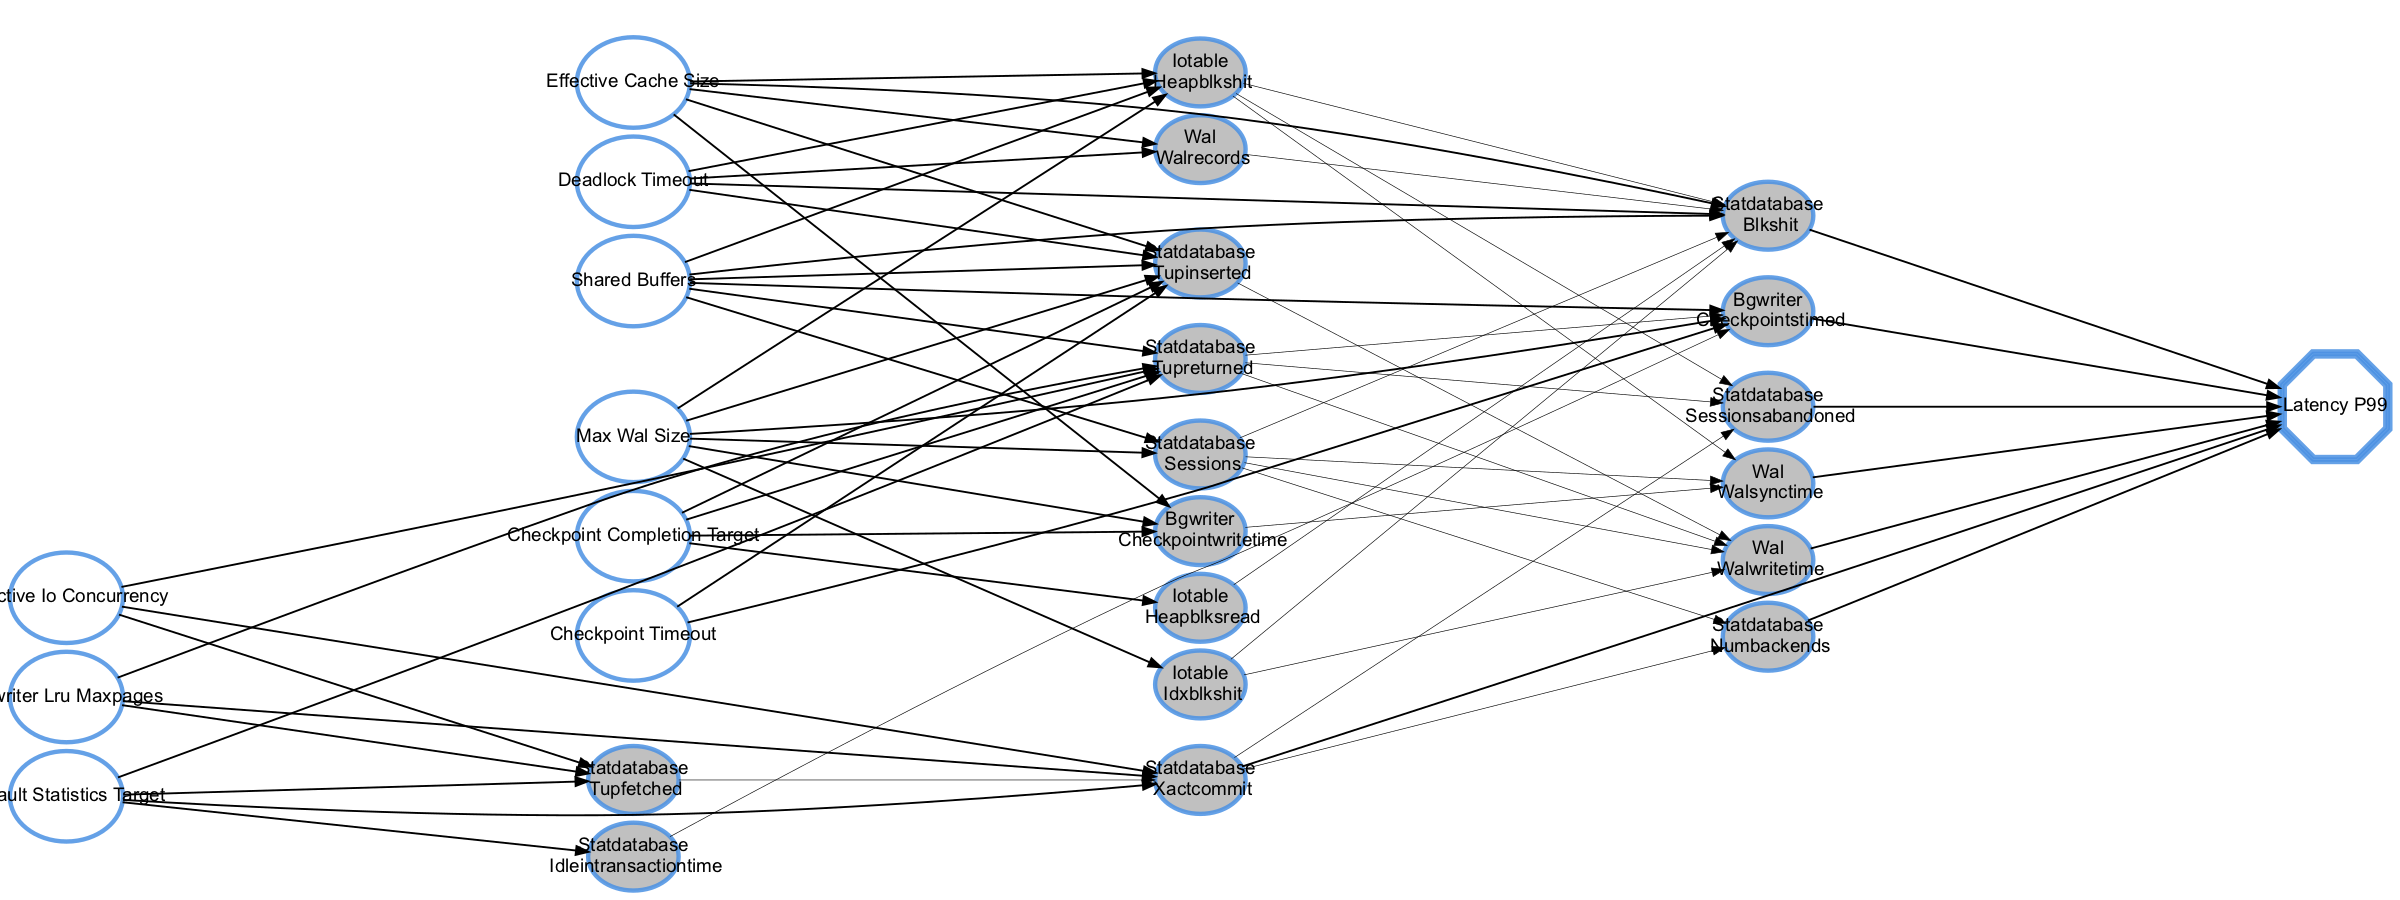

In [23]:
from causalnex.structure import StructureModel
from autorocks.viz.causal_util import plot_struct_customized
from IPython.display import Image


sm = StructureModel(G, create_using=nx.DiGraph)

viz = plot_struct_customized(
    sm,
    "Test",
    param_nodes={p.name for p in sys_param.parameters()},
    sink_nodes={"bench_res.latency_p99"},
)


Image(viz.draw(format="png"))

In [25]:
sm.nodes

NodeView(('deadlock_timeout', 'metrics.io_table.heap_blks_hit', 'metrics.wal.wal_records', 'metrics.stat_database.blks_hit', 'metrics.stat_database.tup_inserted', 'shared_buffers', 'metrics.bg_writer.checkpoints_timed', 'metrics.stat_database.tup_returned', 'metrics.stat_database.sessions', 'bench_res.latency_p99', 'effective_cache_size', 'metrics.bg_writer.checkpoint_write_time', 'metrics.stat_database.sessions_abandoned', 'metrics.wal.wal_sync_time', 'metrics.wal.wal_write_time', 'max_wal_size', 'metrics.io_table.idx_blks_hit', 'checkpoint_timeout', 'checkpoint_completion_target', 'metrics.io_table.heap_blks_read', 'effective_io_concurrency', 'metrics.stat_database.xact_commit', 'metrics.stat_database.tup_fetched', 'bgwriter_lru_maxpages', 'metrics.stat_database.numbackends', 'default_statistics_target', 'metrics.stat_database.idle_in_transaction_time'))

In [24]:
from autorocks.dir_struct import ProcessedDataDir

datasets = {}
debuggers = {}

for node in nx.topological_sort(G):
    parents = {n for n in G.pred[node]}
    target = node

    dataset = BOSystemDataset(
        historic_data_path=ProcessedDataDir / "postgres/latency_p99/ycsb/10_params/100_iter",
        parameters_name=parents,
        objectives_name=[target],
        # transform=lambda X: normalize(X, bounds=torch.tensor(sys_param.bounds().T)),
        target_transform=lambda X: -X,
    )

    debugger = OfflineDebugger(
        observed_dataset=dataset,
        model_callable=lambda train_x, train_y: SingleTaskGPModelNode(train_x=train_x, train_y=train_y),
        shuffle_dataset=True,
    )

    datasets[node] = dataset
    debuggers[node] = debugger

In [29]:
analysis_res = debuggers["metrics.io_table.heap_blks_hit"].regress_against_all_dataset(30)

analysis_res.fig

TypeError: nn.Module.to only accepts floating point or complex dtypes, but got desired dtype=torch.int64

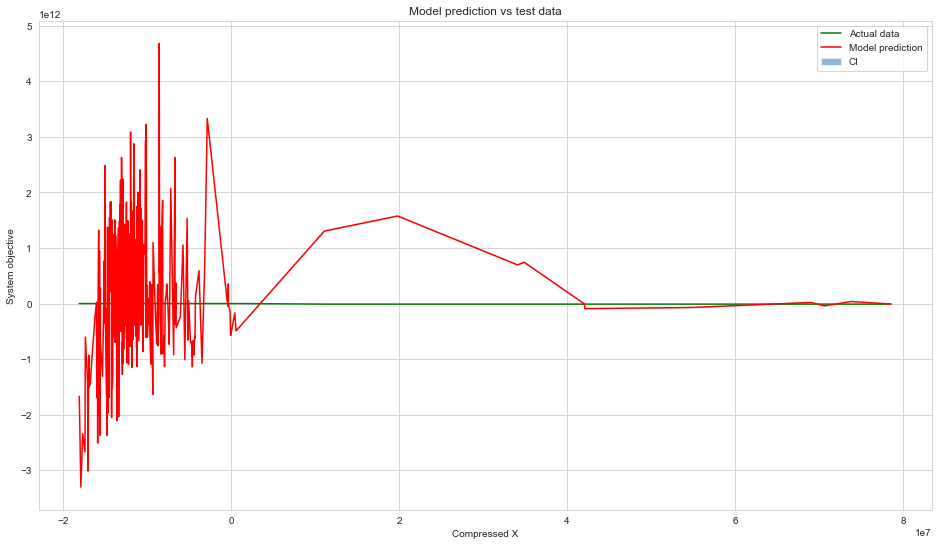

In [27]:
debuggers["bench_res.latency_p99"].regress_on_top_of_test(100)

In [35]:
from autorocks.optimizer.acqf import AcqfOptimizerCfg
from botorch.sampling import SobolQMCNormalSampler
import autorocks.optimizer.acqf as acqf_wrapper


debuggers["metrics.io_table.heap_blks_hit"].regression_at_step(
    30,
    acqf_wrapper=acqf_wrapper.qUpperConfidenceBoundWrapper(
        beta=0.2, sampler=SobolQMCNormalSampler(num_samples=1024), optimizer_cfg=AcqfOptimizerCfg(dim=4)
    ),
)

KeyboardInterrupt: 

In [32]:
len(sm.pred["metrics.io_table.heap_blks_hit"])

4